## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

REDUCE_LR = [ReduceLROnPlateau(factor=0.3, min_lr=1e-12, monitor='val_loss', patience=8, verbose=1), 
             ReduceLROnPlateau(factor=0.7, min_lr=1e-12, monitor='val_loss', patience=10, verbose=1)]

In [8]:
results = {}

for idx, reduce_lr in enumerate(REDUCE_LR):
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    name_tag = "ReduceLROnPlateau_%d" % idx
    results[name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

50000/50000 [==============================] - 2s 33us/step - loss: 0.8560 - acc: 0.7217 - val_loss: 1.4572 - val_acc: 0.5012
Epoch 45/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8542 - acc: 0.7224 - val_loss: 1.4569 - val_acc: 0.5000
Epoch 46/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8541 - acc: 0.7238 - val_loss: 1.4576 - val_acc: 0.5011
Epoch 47/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8529 - acc: 0.7229 - val_loss: 1.4571 - val_acc: 0.5014
Epoch 48/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8525 - acc: 0.7238 - val_loss: 1.4574 - val_acc: 0.5006
Epoch 49/50
50000/50000 [==============================] - 2s 34us/step - loss: 0.8521 - acc: 0.7243 - val_loss: 1.4576 - val_acc: 0.5002
Epoch 50/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.8513 - acc: 0.7250 - val_loss: 1.4584 - val_acc: 0.5002

Epoch 00050: ReduceLROnPlateau reducing learn

50000/50000 [==============================] - 2s 33us/step - loss: 0.6907 - acc: 0.7877 - val_loss: 1.5084 - val_acc: 0.5019
Epoch 42/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.6802 - acc: 0.7915 - val_loss: 1.5179 - val_acc: 0.5019
Epoch 43/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.6713 - acc: 0.7960 - val_loss: 1.5184 - val_acc: 0.5029
Epoch 44/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.6606 - acc: 0.7991 - val_loss: 1.5323 - val_acc: 0.4987
Epoch 45/50
50000/50000 [==============================] - 2s 34us/step - loss: 0.6501 - acc: 0.8039 - val_loss: 1.5343 - val_acc: 0.4999
Epoch 46/50
50000/50000 [==============================] - 2s 34us/step - loss: 0.6410 - acc: 0.8062 - val_loss: 1.5337 - val_acc: 0.5047
Epoch 47/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.6327 - acc: 0.8102 - val_loss: 1.5470 - val_acc: 0.4989
Epoch 48/50
50000/50000 [=====================

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline

def plot_model_score(results):
    color_bar = cm.rainbow(np.linspace(0, 1, len(results)))
    plt.figure(figsize=(6,5))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


    plt.figure(figsize=(6,5))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

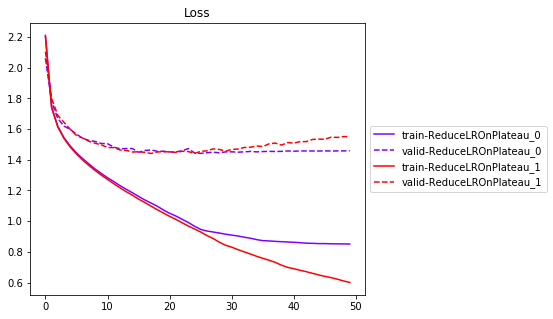

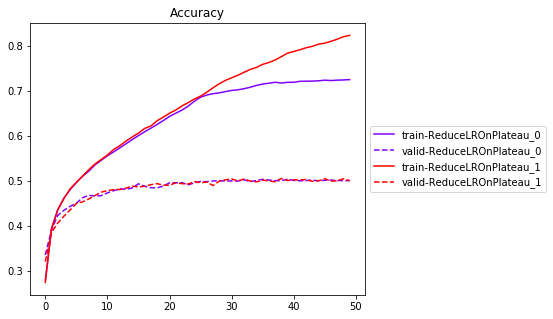

In [10]:
plot_model_score(results)

In [11]:
OPTIMIZER = ['adam', 'rmsprop']

In [12]:
results = {}
reduce_lr = ReduceLROnPlateau(factor=0.3, min_lr=1e-12, monitor='val_loss', patience=8, verbose=1)

for opt in OPTIMIZER:
    keras.backend.clear_session()
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer='rmsprop')

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    name_tag = "opt=%s" % opt
    results[name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 2s 32us/step - loss: 0.2643 - acc: 0.9388 - val_loss: 1.7776 - val_acc: 0.5287

Epoch 00048: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
Epoch 49/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2582 - acc: 0.9420 - val_loss: 1.7776 - val_acc: 0.5293
Epoch 50/50
50000/50000 [==============================] - 2s 32us/step - loss: 0.2580 - acc: 0.9418 - val_loss: 1.7806 - val_acc: 0.5290
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_______________________________________________________

50000/50000 [==============================] - 2s 33us/step - loss: 0.5266 - acc: 0.8406 - val_loss: 1.4528 - val_acc: 0.5395
Epoch 45/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5254 - acc: 0.8417 - val_loss: 1.4544 - val_acc: 0.5391
Epoch 46/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5247 - acc: 0.8426 - val_loss: 1.4537 - val_acc: 0.5381
Epoch 47/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5233 - acc: 0.8434 - val_loss: 1.4547 - val_acc: 0.5391

Epoch 00047: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
Epoch 48/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5222 - acc: 0.8442 - val_loss: 1.4548 - val_acc: 0.5399
Epoch 49/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5218 - acc: 0.8442 - val_loss: 1.4553 - val_acc: 0.5397
Epoch 50/50
50000/50000 [==============================] - 2s 33us/step - loss: 0.5210 - acc: 0.8452 - 

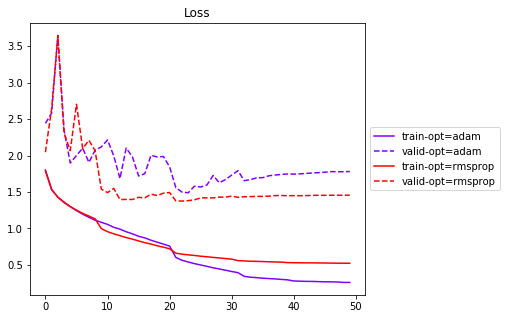

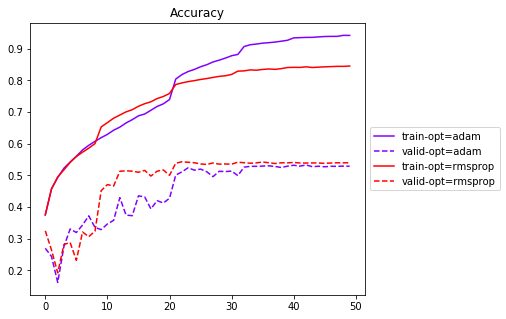

In [13]:
plot_model_score(results)